<a href="https://colab.research.google.com/github/rishi15-t/PP-MM/blob/master/BaseModelGMU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
dataset = pd.read_pickle('/content/drive/My Drive/dataset/w2v_vgg_embeddings.pkl')

In [0]:
'''
import pandas as pd
import h5py
import numpy as np

hf = h5py.File('C:/Users/shram/Desktop/multimodal_imdb.hdf5', 'r')
n1 = pd.Series(hf.get('vgg_features'))
n2 = pd.Series(hf.get('features'))
n3 = pd.Series(hf.get('genres'))
n4 = pd.Series(hf.get('imdb_ids'))

dataset = pd.DataFrame(dict(n1 = n1, n2 = n2, n3 = n3, n4 = n4)).reset_index()
dataset = dataset.rename(columns={"n1": "vgg16_embeddings", "n2": "w2v_embeddings", "n3" : "genres", "n4" : "fileID"})
del dataset['index']
dataset['vgg16_embeddings'] = dataset['vgg16_embeddings'].apply(lambda x : list(map(float, x)))
dataset['w2v_embeddings'] = dataset['w2v_embeddings'].apply(lambda x : list(map(float, x)))
dataset['genres'] = dataset['genres'].apply(lambda x : list(map(int, x)))
dataset

#dataset.to_hdf('w2v_embeddings.h5', key='embeddings', mode='w')
'''

'\nimport pandas as pd\nimport h5py\nimport numpy as np\n\nhf = h5py.File(\'C:/Users/shram/Desktop/multimodal_imdb.hdf5\', \'r\')\nn1 = pd.Series(hf.get(\'vgg_features\'))\nn2 = pd.Series(hf.get(\'features\'))\nn3 = pd.Series(hf.get(\'genres\'))\nn4 = pd.Series(hf.get(\'imdb_ids\'))\n\ndataset = pd.DataFrame(dict(n1 = n1, n2 = n2, n3 = n3, n4 = n4)).reset_index()\ndataset = dataset.rename(columns={"n1": "vgg16_embeddings", "n2": "w2v_embeddings", "n3" : "genres", "n4" : "fileID"})\ndel dataset[\'index\']\ndataset[\'vgg16_embeddings\'] = dataset[\'vgg16_embeddings\'].apply(lambda x : list(map(float, x)))\ndataset[\'w2v_embeddings\'] = dataset[\'w2v_embeddings\'].apply(lambda x : list(map(float, x)))\ndataset[\'genres\'] = dataset[\'genres\'].apply(lambda x : list(map(int, x)))\ndataset\n\n#dataset.to_hdf(\'w2v_embeddings.h5\', key=\'embeddings\', mode=\'w\')\n'

In [0]:
import torch
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split


def Train_Test_Val_Split(data , test_data_fraction = 0.3, val_data_fraction = 0.1) :
    
  
    data_genres_one_hot_encoding = pd.DataFrame.from_items(zip(data['genres'].index, data['genres'].values)).T
    Label_names = np.array(['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'Film-Noir',
       'History', 'Horror', 'Music', 'Musical', 'Mystery', 'Romance',
       'Sci-Fi', 'Short', 'Sport', 'Thriller', 'War', 'Western'])
    data_genres_one_hot_encoding.columns = Label_names
    Data_train, Data_test, Labels_train, Labels_test = train_test_split(data, data_genres_one_hot_encoding, test_size = test_data_fraction)

    Data_train, Data_val, Labels_train, Labels_val = train_test_split(Data_train, Labels_train, test_size = val_data_fraction)

    Data_train = Data_train.reset_index(drop=True)
    Data_test = Data_test.reset_index(drop=True)
    Data_val = Data_val.reset_index(drop=True)
    
    Labels_train = torch.tensor(Labels_train.values)
    Labels_test = torch.tensor(Labels_test.values)
    Labels_val = torch.tensor(Labels_val.values)
    
    return (Data_train, Data_test, Data_val, Labels_train, Labels_test, Labels_val, Label_names)
    
Data_train, Data_test, Data_val, Labels_train_tensor, Labels_test_tensor, Labels_val_tensor, Label_names = Train_Test_Val_Split(dataset)

Data_train_tensor_text = torch.tensor(Data_train['w2v_embeddings'])
Data_test_tensor_text = torch.tensor(Data_test['w2v_embeddings'])
Data_val_tensor_text = torch.tensor(Data_val['w2v_embeddings'])

Data_train_tensor_image = torch.tensor(Data_train['vgg16_embeddings'])
Data_test_tensor_image = torch.tensor(Data_test['vgg16_embeddings'])
Data_val_tensor_image = torch.tensor(Data_val['vgg16_embeddings'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  # Remove the CWD from sys.path while we load stuff.


In [0]:
from torch import nn


#source: https://github.com/Duncanswilson/maxout-pytorch/blob/master/maxout_pytorch.ipynb
class ListModule(object):
    def __init__(self, module, prefix, *args):
        self.module = module
        self.prefix = prefix
        self.num_module = 0
        for new_module in args:
            self.append(new_module)

    def append(self, new_module):
        if not isinstance(new_module, nn.Module):
            raise ValueError('Not a Module')
        else:
            self.module.add_module(self.prefix + str(self.num_module), new_module)
            self.num_module += 1

    def __len__(self):
        return self.num_module

    def __getitem__(self, i):
        if i < 0 or i >= self.num_module:
            raise IndexError('Out of bound')
        return getattr(self.module, self.prefix + str(i))


class Maxout_MLP(nn.Module):
    
    def __init__(self, hidden_layer_size1, hidden_layer_size2, dropout, num_maxout_units=2):
        
        super(Maxout_MLP, self).__init__()
        self.fc1_list = ListModule(self, "fc1_")
        self.fc2_list = ListModule(self, "fc2_")
        self.hidden_layer_size1 = hidden_layer_size1
        self.hidden_layer_size2 = hidden_layer_size2
        for _ in range(num_maxout_units):
            self.fc1_list.append(nn.Linear(self.hidden_layer_size1, self.hidden_layer_size2))
            self.fc2_list.append(nn.Linear(self.hidden_layer_size2, self.hidden_layer_size2))
        self.dropout = nn.Dropout(p=dropout)
        self.bn0 = nn.BatchNorm1d(self.hidden_layer_size1)
        self.bn1 = nn.BatchNorm1d(self.hidden_layer_size2)
        self.bn2 = nn.BatchNorm1d(self.hidden_layer_size2)

    def forward(self, x): 
        
        x = x.view(-1, self.hidden_layer_size1)
        x = self.bn0(x)
        x = self.maxout(x, self.fc1_list)
        x = self.bn1(x)
        x = self.dropout(x)
        x = self.maxout(x, self.fc2_list)
        x = self.bn2(x)
        return x

    def maxout(self, x, layer_list):
        
        max_output = layer_list[0](x)
        for _, layer in enumerate(layer_list, start=1):
            max_output = torch.max(max_output, layer(x))
        return max_output


class GMU(nn.Module):

    def __init__(self, num_maxout_units = 2, hidden_layer_size = 512, text_embeddings_size = 300, img_embeddings_size = 4096, num_labels = 23, hidden_activation = None, dropout = 0.1):

        super(GMU, self).__init__()
        self.num_labels = num_labels
        self.hidden_layer_size = hidden_layer_size

        self.linear_h_text = torch.nn.Linear(text_embeddings_size, self.hidden_layer_size, bias = False)
        self.linear_h_image = torch.nn.Linear(img_embeddings_size, self.hidden_layer_size, bias = False)
        self.linear_z = torch.nn.Linear(text_embeddings_size + img_embeddings_size, self.hidden_layer_size, bias = False)

        self.tanh = torch.nn.Tanh()
        self.sigmoid = torch.nn.Sigmoid()

        self.dropout = nn.Dropout(p=dropout)
        self.linear = torch.nn.Linear(self.hidden_layer_size, self.num_labels)
        
        self.maxout = Maxout_MLP(self.hidden_layer_size, self.hidden_layer_size, dropout, num_maxout_units=num_maxout_units)

    def forward(self, image_embeddings, text_embeddings):
        
        image_h = self.linear_h_image(image_embeddings)
        image_h = self.tanh(image_h)
        text_h = self.linear_h_text(text_embeddings)
        text_h = self.tanh(text_h)
        concat = torch.cat((image_embeddings, text_embeddings), 1)
        z = self.linear_z(concat)
        z = self.sigmoid(z)
        gmu_output = z*image_h + (1-z)*text_h
        
        maxout_mlp_output = self.maxout(gmu_output)

        logits = self.linear(maxout_mlp_output)
        if(self.training) :
            return logits
        else :
            output = self.sigmoid(logits)
            return output


In [0]:
import torch
from torch.nn import BCEWithLogitsLoss
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm, trange
from sklearn import metrics
#!pip install transformers
#from transformers import get_linear_schedule_with_warmup
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
import pandas as pd
import numpy as np
import time
import datetime


class Training_Testing_MM():

    def __init__(self, Data_train_tensor_text, Data_train_tensor_image, Labels_train_tensor, 
                 Data_test_tensor_text, Data_test_tensor_image, Labels_test_tensor, 
                 Data_val_tensor_text, Data_val_tensor_image, Labels_val_tensor,
                 Label_names = None, hidden_layer_size = 512, num_maxout_units = 2, weight_decay= 0.1, scheduler_step_size = 30, scheduler_lr_fraction = 0.8,
                 hidden_activation = "tanh", batch_size = 32, epochs = 10, sigmoid_thresh = 0.2, learning_rate = 2e-5, num_labels = 23, dropout = 0.1):


      self.model = GMU(num_maxout_units = num_maxout_units, hidden_layer_size = hidden_layer_size, hidden_activation = hidden_activation, dropout = dropout).cuda()
      self.label_names = Label_names
      self.num_labels = num_labels
      self.batch_size = batch_size
      self.learning_rate = learning_rate
      self.epochs = epochs
      self.sigmoid_thresh = sigmoid_thresh
      self.scheduler_step_size = scheduler_step_size
      self.scheduler_lr_fraction = scheduler_lr_fraction
      self.weight_decay = weight_decay
      self.optimizer = self.SetOptimizer()
      self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
      self.results = pd.DataFrame(0, index=['Recall','Precision','F_Score'], columns=['micro', 'macro', 'weighted', 'samples']).astype(float)
      self.epoch_loss_set = []
      self.train_dataloader = self.SetTrainDataloader_MM(Data_train_tensor_text, Data_train_tensor_image, Labels_train_tensor)
      self.test_dataloader = self.SetTestDataloader_MM(Data_test_tensor_text, Data_test_tensor_image, Labels_test_tensor) 
      self.scheduler = self.SetScheduler()

      self.val_accuracy_set = [] 
      self.val_dataloader = self.SetValDataloader_MM(Data_val_tensor_text, Data_val_tensor_image, Labels_val_tensor)
      self.class_wise_metrics = None
      self.predictions = None

    def SetOptimizer(self) :

      optimizer = AdamW(self.model.parameters(), lr=self.learning_rate,  eps = 1e-6, weight_decay=self.weight_decay)
      return(optimizer)

    

    def SetScheduler(self) :

      '''
      scheduler = get_linear_schedule_with_warmup(self.optimizer, num_warmup_steps = 10, 
                                                 num_training_steps = self.epochs*len(self.train_dataloader))
      '''
      scheduler = StepLR(self.optimizer, step_size = self.scheduler_step_size, gamma = self.scheduler_lr_fraction)
      return(scheduler) 



    def Get_Metrics(self, actual, predicted) :

      #acc = metrics.accuracy_score(actual, predicted)
      #hamming = metrics.hamming_loss(actual, predicted)
      #(metrics.roc_auc_score(actual, predicted, average=average)
      averages = ('micro', 'macro', 'weighted', 'samples')
      for average in averages:
          precision, recall, fscore, _ = metrics.precision_recall_fscore_support(actual, predicted, average=average)
          self.results[average]['Recall'] += recall
          self.results[average]['Precision'] += precision
          self.results[average]['F_Score'] += fscore



    #source: https://mccormickml.com/2019/07/22/BERT-fine-tuning/
    def Plot_Training_Epoch_Loss(self) :

      sns.set(style='darkgrid')
      sns.set(font_scale=1.5)
      plt.rcParams["figure.figsize"] = (12,6)
      plt.plot(self.epoch_loss_set, 'b-o')
      plt.title("Training loss")
      plt.xlabel("Epoch")
      plt.ylabel("Loss")
      plt.savefig('Training_Epoch_Loss.png',bbox_inches='tight')
      plt.show()

    
    def Plot_Training_Epoch_Accuracy(self) :

      sns.set(style='darkgrid')
      sns.set(font_scale=1.5)
      plt.rcParams["figure.figsize"] = (12,6)
      plt.plot(self.val_accuracy_set, 'b-o')
      plt.title("Micro F1 Score")
      plt.xlabel("Epoch")
      plt.ylabel("Validation Accuracy")
      plt.savefig('Training_Validation_Accuracy.png',bbox_inches='tight')
      plt.show()


    #source: https://mccormickml.com/2019/07/22/BERT-fine-tuning/
    def format_time(self, elapsed):
      '''
      Takes a time in seconds and returns a string hh:mm:ss
      '''
      # Round to the nearest second.
      elapsed_rounded = int(round((elapsed)))
      return str(datetime.timedelta(seconds=elapsed_rounded))


    def SetTrainDataloader_MM(self, Data_train_tensor_text, Data_train_tensor_image, Labels_train_tensor) :

      train_dataset = TensorDataset(Data_train_tensor_text, Data_train_tensor_image, Labels_train_tensor)
      train_sampler = RandomSampler(train_dataset)
      train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size = self.batch_size)
      return(train_dataloader)


    def SetTestDataloader_MM(self, Data_test_tensor_text, Data_test_tensor_image, Labels_test_tensor) :
      
      test_dataset = TensorDataset(Data_test_tensor_text, Data_test_tensor_image, Labels_test_tensor)
      test_sampler = SequentialSampler(test_dataset)
      #test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size = self.batch_size)
      test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size = Data_test_tensor_text.shape[0])
      return(test_dataloader)

    
    def SetValDataloader_MM(self, Data_val_tensor_text, Data_val_tensor_image, Labels_val_tensor) :
      
      val_dataset = TensorDataset(Data_val_tensor_text, Data_val_tensor_image, Labels_val_tensor)
      val_sampler = SequentialSampler(val_dataset)
      #test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size = self.batch_size)
      val_dataloader = DataLoader(val_dataset, sampler=val_sampler, batch_size = Data_val_tensor_text.shape[0])
      return(val_dataloader)

   
    def Train(self) :

      for _ in trange(self.epochs, desc="Epoch"):
        
        self.model.train()
        epoch_loss = 0

        # Measure how long the training epoch takes.
        t0 = time.time()
    
        for step_num, batch_data in enumerate(self.train_dataloader):

          # Progress update every 30 batches.
          if step_num % 30 == 0 and not step_num == 0:
            elapsed = self.format_time(time.time() - t0)
            print('  Batch : ',step_num, ' , Time elapsed : ',elapsed)

          samples_text, samples_image, labels = tuple(t.to(self.device) for t in batch_data)
          self.optimizer.zero_grad()
          logits = self.model(samples_image.float(), samples_text.float())
          loss_fct = BCEWithLogitsLoss()
          batch_loss = loss_fct(logits.view(-1, self.num_labels).float(), labels.view(-1, self.num_labels).float())
          batch_loss.backward()
          self.optimizer.step()
          self.scheduler.step()
          epoch_loss += batch_loss.item()

        avg_epoch_loss = epoch_loss/len(self.train_dataloader)
        print("\nTrain loss for epoch: ",avg_epoch_loss)
        print("\nTraining epoch took: {:}".format(self.format_time(time.time() - t0)))
        self.epoch_loss_set.append(avg_epoch_loss)

        #Validation on the epoch
        self.model.eval()
        epoch_f1_score = 0

        for batch_data in self.val_dataloader:
          samples_text, samples_image, labels = tuple(t.to(self.device) for t in batch_data)
          with torch.no_grad():
            output = self.model(samples_image.float(), samples_text.float())

          threshold = torch.Tensor([self.sigmoid_thresh]).to(self.device)
          predictions = (output > threshold).int()

          predictions = predictions.detach().cpu().numpy()
          labels = labels.to('cpu').numpy()
      
          micro_f_score = metrics.f1_score(labels,predictions,average="micro")
          epoch_f1_score += micro_f_score

        avg_val_f1_score = epoch_f1_score/len(self.val_dataloader)
        print("\n Micro F1 score for epoch: ",avg_val_f1_score,"\n")
        self.val_accuracy_set.append(avg_val_f1_score)

      #torch.save(self.model.state_dict(), "/content/drive/My Drive/dataset/model.pt")
      self.Plot_Training_Epoch_Loss()
      self.Plot_Training_Epoch_Accuracy()
   

    def Test(self) :

      # Put model in evaluation mode to evaluate loss on the test set
      self.model.eval()

      for batch_data in self.test_dataloader:
  
        samples_text, samples_image, labels = tuple(t.to(self.device) for t in batch_data)
      
        # Telling the model not to compute or store gradients, saving memory and speeding up validation
        # Forward pass, calculate logit predictions
        with torch.no_grad():
          output = self.model(samples_image.float(), samples_text.float())

        threshold = torch.Tensor([self.sigmoid_thresh]).to(self.device)
        predictions = (output > threshold).int()

        # Move preds and labels to CPU
        predictions = predictions.detach().cpu().numpy()
        labels = labels.to('cpu').numpy()

        self.predictions = predictions
        self.Get_Metrics(labels, predictions)
        self.class_wise_metrics = metrics.classification_report(labels, predictions, target_names= list(self.label_names))
        
    
      self.results = self.results/len(self.test_dataloader)
      #print("Test data metrics : \n")

      #print("\nGenres with no predicted samples : ", self.label_names[np.where(np.sum(predictions, axis=0) == 0)[0]])
      
      return(self.results)






Epoch:   0%|          | 0/70 [00:00<?, ?it/s]

  Batch :  30  , Time elapsed :  0:00:01







Epoch:   1%|▏         | 1/70 [00:01<01:30,  1.31s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.3291114552412182

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.5201288244766505 

  Batch :  30  , Time elapsed :  0:00:01







Epoch:   3%|▎         | 2/70 [00:02<01:28,  1.30s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.2098727305419743

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.5574876719439398 

  Batch :  30  , Time elapsed :  0:00:01







Epoch:   4%|▍         | 3/70 [00:03<01:27,  1.30s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.19584854505956173

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.5725061776563922 

  Batch :  30  , Time elapsed :  0:00:01







Epoch:   6%|▌         | 4/70 [00:05<01:26,  1.31s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.18739380384795368

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.5903301595152715 

  Batch :  30  , Time elapsed :  0:00:01
  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.18182427622377872

Training epoch took: 0:00:01







Epoch:   7%|▋         | 5/70 [00:07<01:46,  1.63s/it]


 Micro F1 score for epoch:  0.5972939729397294 

  Batch :  30  , Time elapsed :  0:00:01







Epoch:   9%|▊         | 6/70 [00:08<01:39,  1.55s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.17689094529487193

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.5894843276036401 

  Batch :  30  , Time elapsed :  0:00:01







Epoch:  10%|█         | 7/70 [00:10<01:32,  1.47s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.1738820867612958

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.5970338445937381 

  Batch :  30  , Time elapsed :  0:00:01







Epoch:  11%|█▏        | 8/70 [00:11<01:27,  1.41s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.1720010070130229

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.6078119260438349 

  Batch :  30  , Time elapsed :  0:00:01







Epoch:  13%|█▎        | 9/70 [00:12<01:23,  1.38s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.16979025956243277

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.589319530362328 

  Batch :  30  , Time elapsed :  0:00:01







Epoch:  14%|█▍        | 10/70 [00:14<01:21,  1.36s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.1675899149850011

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.6124794745484401 

  Batch :  30  , Time elapsed :  0:00:01







Epoch:  16%|█▌        | 11/70 [00:15<01:19,  1.34s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.16283598053269088

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.6022052586938083 

  Batch :  30  , Time elapsed :  0:00:01







Epoch:  17%|█▋        | 12/70 [00:16<01:16,  1.32s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.16121619357727468

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.6067717882899402 

  Batch :  30  , Time elapsed :  0:00:01







Epoch:  19%|█▊        | 13/70 [00:18<01:15,  1.32s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.1587855403777212

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.6137762806365432 

  Batch :  30  , Time elapsed :  0:00:01







Epoch:  20%|██        | 14/70 [00:19<01:13,  1.31s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.15760346571914852

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.6117053238793415 

  Batch :  30  , Time elapsed :  0:00:01







Epoch:  21%|██▏       | 15/70 [00:20<01:12,  1.32s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.154107945272699

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.6144349477682812 

  Batch :  30  , Time elapsed :  0:00:01
  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.15089895413257182

Training epoch took: 0:00:01







Epoch:  23%|██▎       | 16/70 [00:23<01:29,  1.65s/it]


 Micro F1 score for epoch:  0.6221303948576676 

  Batch :  30  , Time elapsed :  0:00:01







Epoch:  24%|██▍       | 17/70 [00:24<01:21,  1.55s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.14944923156872392

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.6049964647654961 

  Batch :  30  , Time elapsed :  0:00:01







Epoch:  26%|██▌       | 18/70 [00:25<01:16,  1.47s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.14656096207909286

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.6064214827787507 

  Batch :  30  , Time elapsed :  0:00:01







Epoch:  27%|██▋       | 19/70 [00:26<01:12,  1.42s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.1455994185525924

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.6119350694849935 

  Batch :  30  , Time elapsed :  0:00:01







Epoch:  29%|██▊       | 20/70 [00:28<01:09,  1.39s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.13894485274795443

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.6125 

  Batch :  30  , Time elapsed :  0:00:01







Epoch:  30%|███       | 21/70 [00:29<01:08,  1.40s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.13685098150745034

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.6130849718293664 

  Batch :  30  , Time elapsed :  0:00:01







Epoch:  31%|███▏      | 22/70 [00:31<01:05,  1.37s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.13365904882084578

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.6108612936700103 

  Batch :  30  , Time elapsed :  0:00:01







Epoch:  33%|███▎      | 23/70 [00:32<01:03,  1.35s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.13264258007984608

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.6114239742558325 

  Batch :  30  , Time elapsed :  0:00:01







Epoch:  34%|███▍      | 24/70 [00:33<01:01,  1.34s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.12957116775214672

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.6177221062398516 

  Batch :  30  , Time elapsed :  0:00:01







Epoch:  36%|███▌      | 25/70 [00:34<00:59,  1.32s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.12524628394749016

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.6103851046605759 

  Batch :  30  , Time elapsed :  0:00:01







Epoch:  37%|███▋      | 26/70 [00:36<00:57,  1.31s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.1212027749279514

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.6103971286326271 

  Batch :  30  , Time elapsed :  0:00:01







Epoch:  39%|███▊      | 27/70 [00:37<00:56,  1.31s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.119313700706698

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.6176957914503479 

  Batch :  30  , Time elapsed :  0:00:01
  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.11883400310762227

Training epoch took: 0:00:01







Epoch:  40%|████      | 28/70 [00:39<01:08,  1.64s/it]


 Micro F1 score for epoch:  0.6061592097617663 

  Batch :  30  , Time elapsed :  0:00:01







Epoch:  41%|████▏     | 29/70 [00:41<01:03,  1.55s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.11349973431788385

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.617693169092945 

  Batch :  30  , Time elapsed :  0:00:01







Epoch:  43%|████▎     | 30/70 [00:42<00:59,  1.49s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.10885613528080285

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.6237971244197894 

  Batch :  30  , Time elapsed :  0:00:01







Epoch:  44%|████▍     | 31/70 [00:43<00:55,  1.43s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.1066751255420968

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.6146663630152586 

  Batch :  30  , Time elapsed :  0:00:01







Epoch:  46%|████▌     | 32/70 [00:45<00:53,  1.41s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.10450711951125413

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.621673649643302 

  Batch :  30  , Time elapsed :  0:00:01







Epoch:  47%|████▋     | 33/70 [00:46<00:50,  1.37s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.10126651055179536

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.6165599370857207 

  Batch :  30  , Time elapsed :  0:00:01







Epoch:  49%|████▊     | 34/70 [00:47<00:48,  1.36s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.09671843389514834

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.6161286694410077 

  Batch :  30  , Time elapsed :  0:00:01







Epoch:  50%|█████     | 35/70 [00:49<00:46,  1.34s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.09238966670818627

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.6089957437018291 

  Batch :  30  , Time elapsed :  0:00:01







Epoch:  51%|█████▏    | 36/70 [00:50<00:45,  1.33s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.08991741109639406

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.6144713261648747 

  Batch :  30  , Time elapsed :  0:00:01







Epoch:  53%|█████▎    | 37/70 [00:51<00:43,  1.32s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.0888107743812725

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.6162856177497466 

  Batch :  30  , Time elapsed :  0:00:01







Epoch:  54%|█████▍    | 38/70 [00:53<00:41,  1.30s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.08572106203064322

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.6202672605790647 

  Batch :  30  , Time elapsed :  0:00:01







Epoch:  56%|█████▌    | 39/70 [00:54<00:40,  1.31s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.08181857177987695

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.6109439429399309 

  Batch :  30  , Time elapsed :  0:00:01
  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.07860152889043093

Training epoch took: 0:00:01







Epoch:  57%|█████▋    | 40/70 [00:56<00:48,  1.62s/it]


 Micro F1 score for epoch:  0.6151635720601237 

  Batch :  30  , Time elapsed :  0:00:01







Epoch:  59%|█████▊    | 41/70 [00:58<00:44,  1.54s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.0763794535305351

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.6157293300470535 

  Batch :  30  , Time elapsed :  0:00:01







Epoch:  60%|██████    | 42/70 [00:59<00:41,  1.48s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.07419239263981581

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.6089203460285362 

  Batch :  30  , Time elapsed :  0:00:01







Epoch:  61%|██████▏   | 43/70 [01:00<00:38,  1.43s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.07127145666163415

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.6148782093482554 

  Batch :  30  , Time elapsed :  0:00:01







Epoch:  63%|██████▎   | 44/70 [01:02<00:36,  1.41s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.06665390043053776

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.6148596587782059 

  Batch :  30  , Time elapsed :  0:00:01







Epoch:  64%|██████▍   | 45/70 [01:03<00:34,  1.39s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.0656753450166434

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.6155218554861731 

  Batch :  30  , Time elapsed :  0:00:01







Epoch:  66%|██████▌   | 46/70 [01:04<00:33,  1.38s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.06331887241685763

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.615811681101488 

  Batch :  30  , Time elapsed :  0:00:01







Epoch:  67%|██████▋   | 47/70 [01:06<00:31,  1.37s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.061557184148114175

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.617033276931754 

  Batch :  30  , Time elapsed :  0:00:01







Epoch:  69%|██████▊   | 48/70 [01:07<00:29,  1.36s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.05787440633866936

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.6204967554262698 

  Batch :  30  , Time elapsed :  0:00:01







Epoch:  70%|███████   | 49/70 [01:08<00:28,  1.35s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.05629783135373145

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.6208651399491094 

  Batch :  30  , Time elapsed :  0:00:01







Epoch:  71%|███████▏  | 50/70 [01:10<00:26,  1.35s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.05415569897741079

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.6168390612835057 

  Batch :  30  , Time elapsed :  0:00:01







Epoch:  73%|███████▎  | 51/70 [01:11<00:25,  1.35s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.05239559157053009

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.6168307967770814 

  Batch :  30  , Time elapsed :  0:00:01
  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.05130000808276236

Training epoch took: 0:00:01







Epoch:  74%|███████▍  | 52/70 [01:13<00:29,  1.66s/it]


 Micro F1 score for epoch:  0.6148723640399556 

  Batch :  30  , Time elapsed :  0:00:01







Epoch:  76%|███████▌  | 53/70 [01:15<00:26,  1.57s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.04731342714512721

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.616331096196868 

  Batch :  30  , Time elapsed :  0:00:01







Epoch:  77%|███████▋  | 54/70 [01:16<00:23,  1.50s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.04560654022498056

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.6112354521038496 

  Batch :  30  , Time elapsed :  0:00:01







Epoch:  79%|███████▊  | 55/70 [01:17<00:21,  1.45s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.04476033983519301

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.6192060323796851 

  Batch :  30  , Time elapsed :  0:00:01







Epoch:  80%|████████  | 56/70 [01:19<00:19,  1.41s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.04346354864537716

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.61875 

  Batch :  30  , Time elapsed :  0:00:01







Epoch:  81%|████████▏ | 57/70 [01:20<00:18,  1.39s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.041890138818416744

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.6190102120974077 

  Batch :  30  , Time elapsed :  0:00:01







Epoch:  83%|████████▎ | 58/70 [01:22<00:16,  1.40s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.03974875085987151

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.6212661613909942 

  Batch :  30  , Time elapsed :  0:00:01







Epoch:  84%|████████▍ | 59/70 [01:23<00:15,  1.40s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.03807830036384985

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.6227196418578623 

  Batch :  30  , Time elapsed :  0:00:01







Epoch:  86%|████████▌ | 60/70 [01:24<00:13,  1.37s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.03798324891249649

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.6191657271702368 

  Batch :  30  , Time elapsed :  0:00:01







Epoch:  87%|████████▋ | 61/70 [01:25<00:12,  1.34s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.03680395529954694

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.6177451634422949 

  Batch :  30  , Time elapsed :  0:00:01







Epoch:  89%|████████▊ | 62/70 [01:27<00:10,  1.33s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.03499021186144091

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.6195159686153167 

  Batch :  30  , Time elapsed :  0:00:01







Epoch:  90%|█████████ | 63/70 [01:28<00:09,  1.33s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.03369474518694915

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.618589025755879 

  Batch :  30  , Time elapsed :  0:00:01







Epoch:  91%|█████████▏| 64/70 [01:30<00:08,  1.36s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.03150355440448038

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.6132255529358931 

  Batch :  30  , Time elapsed :  0:00:02







Epoch:  93%|█████████▎| 65/70 [01:32<00:08,  1.67s/it]

  Batch :  60  , Time elapsed :  0:00:02

Train loss for epoch:  0.03120812852284871

Training epoch took: 0:00:02

 Micro F1 score for epoch:  0.6166177466696771 

  Batch :  30  , Time elapsed :  0:00:01







Epoch:  94%|█████████▍| 66/70 [01:33<00:06,  1.59s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.030795978906098753

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.6146933273421703 

  Batch :  30  , Time elapsed :  0:00:01







Epoch:  96%|█████████▌| 67/70 [01:35<00:04,  1.52s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.029256133624585345

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.6207513416815743 

  Batch :  30  , Time elapsed :  0:00:01







Epoch:  97%|█████████▋| 68/70 [01:36<00:02,  1.47s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.027755427494412288

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.6191226096737907 

  Batch :  30  , Time elapsed :  0:00:01







Epoch:  99%|█████████▊| 69/70 [01:37<00:01,  1.44s/it]

  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.026977628527674824

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.6198337950138504 

  Batch :  30  , Time elapsed :  0:00:01







Epoch: 100%|██████████| 70/70 [01:39<00:00,  1.43s/it]






  Batch :  60  , Time elapsed :  0:00:01

Train loss for epoch:  0.026749749144073576

Training epoch took: 0:00:01

 Micro F1 score for epoch:  0.6162295449450795 



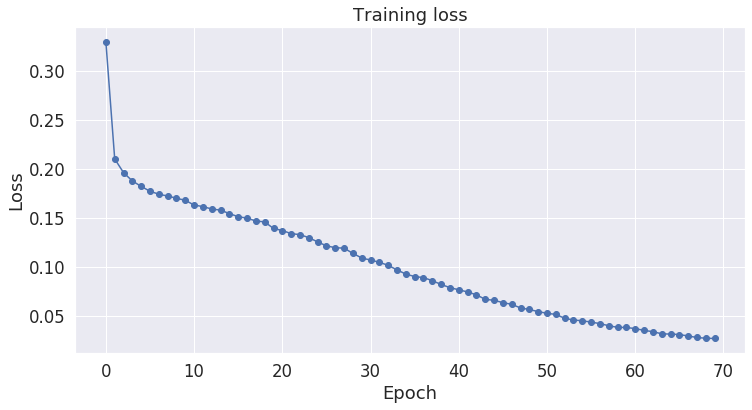

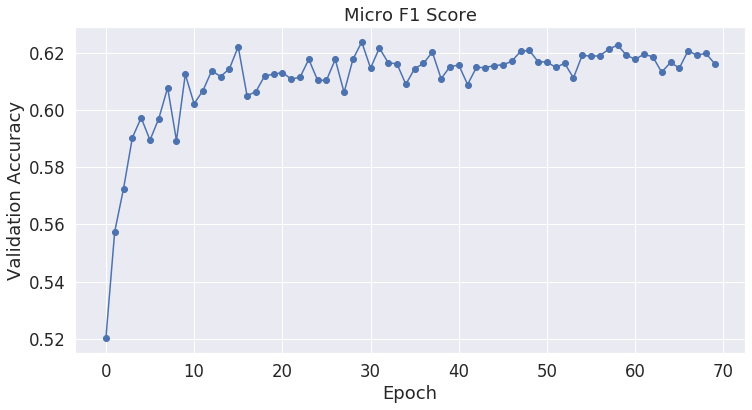

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,micro,macro,weighted,samples
Recall,0.613612,0.523774,0.613612,0.663439
Precision,0.630665,0.586797,0.623179,0.667576
F_Score,0.622021,0.548512,0.615571,0.622534


In [0]:
train_test = Training_Testing_MM( Data_train_tensor_text, Data_train_tensor_image, Labels_train_tensor, 
                                  Data_test_tensor_text, Data_test_tensor_image, Labels_test_tensor, 
                                  Data_val_tensor_text, Data_val_tensor_image, Labels_val_tensor, Label_names=Label_names, 
                                  hidden_layer_size = 512, epochs = 70, batch_size= 256, learning_rate=0.01, dropout=0.7, scheduler_step_size = 300, 
                                  scheduler_lr_fraction = 0.85, sigmoid_thresh = 0.5, num_maxout_units = 10, weight_decay = 0.1)
train_test.Train()
train_test.Test()

In [0]:
print(train_test.class_wise_metrics)

              precision    recall  f1-score   support

      Action       0.73      0.80      0.76      4186
   Adventure       0.66      0.68      0.67      2525
   Animation       0.51      0.50      0.50      1643
   Biography       0.59      0.57      0.58      1568
      Comedy       0.58      0.62      0.60      1063
       Crime       0.62      0.57      0.59      1085
 Documentary       0.58      0.51      0.55       857
       Drama       0.69      0.67      0.68       858
      Family       0.73      0.74      0.73       661
     Fantasy       0.47      0.42      0.44       594
   Film-Noir       0.70      0.64      0.67       635
     History       0.49      0.43      0.46       587
      Horror       0.62      0.51      0.56       503
       Music       0.50      0.26      0.35       443
     Musical       0.59      0.67      0.63       418
     Mystery       0.37      0.31      0.34       342
     Romance       0.62      0.47      0.54       345
      Sci-Fi       0.74    